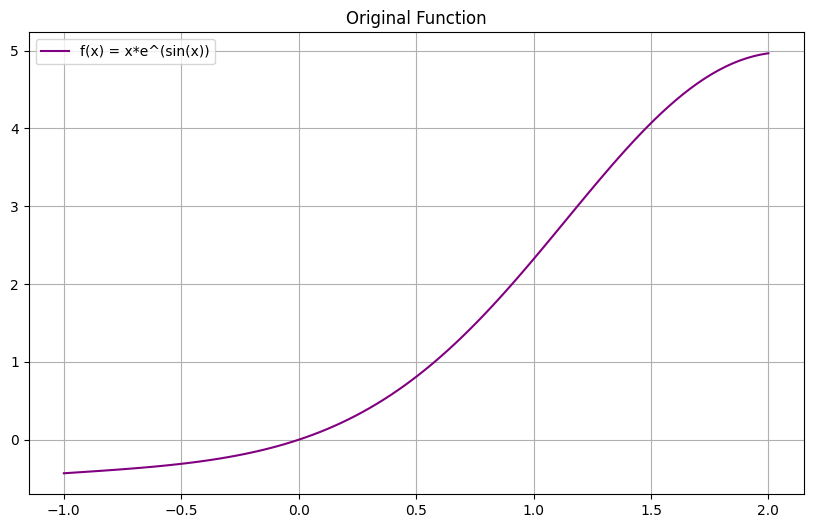

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple

# here i ddefine the function f(x) = x * e^(sin(x))
def f(x: float) -> float:
    return x * np.exp(np.sin(x))


x_test = np.linspace(-1, 2, 100)
plt.figure(figsize=(10, 6))
plt.plot(x_test, f(x_test), 'purple', label='f(x) = x*e^(sin(x))')
plt.title('Original Function')
plt.grid(True)
plt.legend()
plt.show()

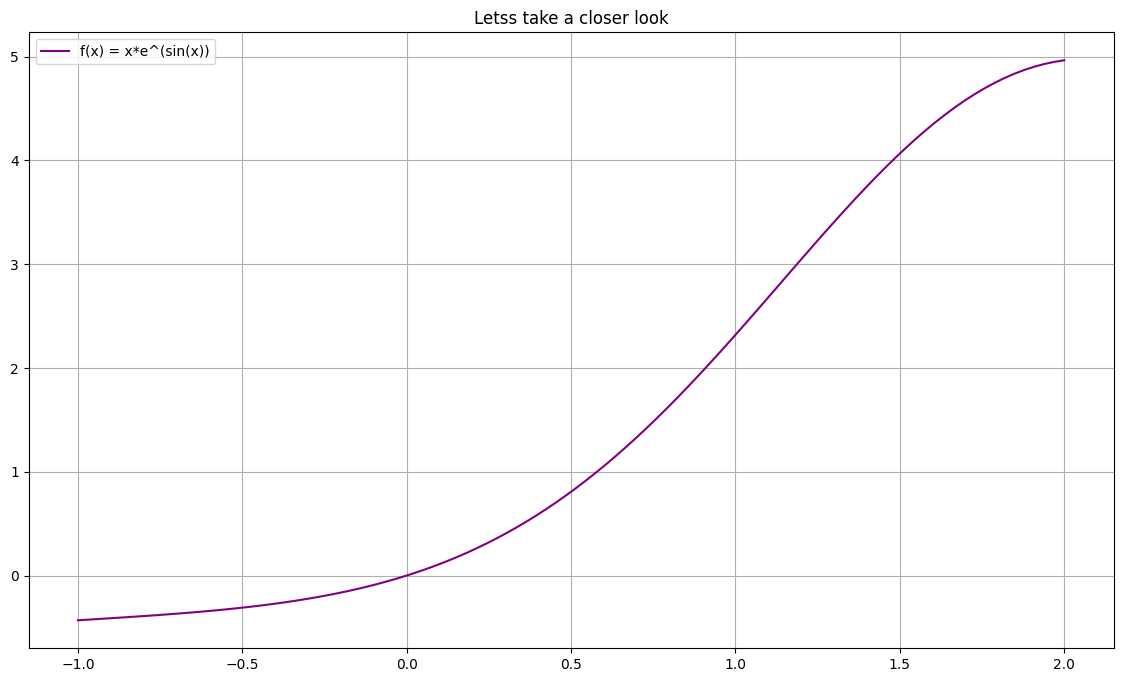

In [38]:
plt.figure(figsize=(14, 8))
plt.plot(x_test, f(x_test), 'purple', label='f(x) = x*e^(sin(x))')
plt.title('Letss take a closer look')
plt.grid(True)
plt.legend()
plt.show()

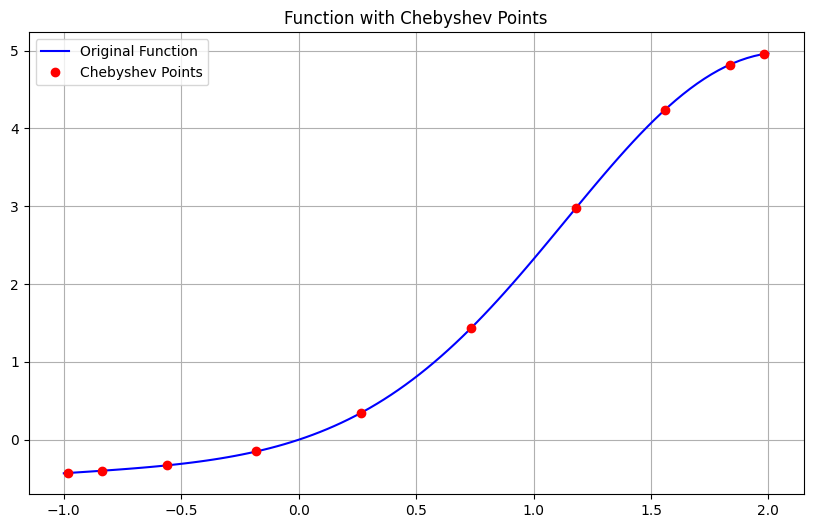

In [39]:
def chebyshev_points(n: int, a: float, b: float) -> np.ndarray:
    k = np.arange(n)
    points = np.cos((2*k + 1)*np.pi/(2*n))
    return 0.5*(b-a)*points + 0.5*(b+a) # by the formula on the slidess


a, b = -1, 2
n_points = 10 # 5 points will give us the really bad result 
x_cheb = np.sort(chebyshev_points(n_points, a, b))
y_cheb = f(x_cheb)

plt.figure(figsize=(10, 6))
plt.plot(x_test, f(x_test), 'b-', label='Original Function')
plt.plot(x_cheb, y_cheb, 'ro', label='Chebyshev Points')
plt.title('Function with Chebyshev Points')
plt.grid(True)
plt.legend()
plt.show()

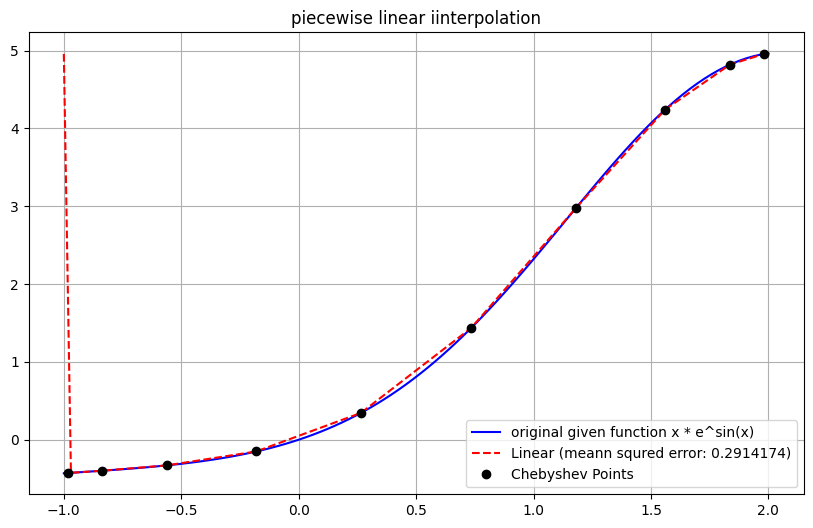

In [40]:
def piecewise_linear(x: float, x_points: np.ndarray, y_points: np.ndarray) -> float:
    for i in range(len(x_points)-1):
        if x_points[i] <= x <= x_points[i+1]:
            x0, x1 = x_points[i], x_points[i+1]
            y0, y1 = y_points[i], y_points[i+1]
            return y0 + (y1 - y0)*(x - x0)/(x1 - x0)
    return y_points[-1]

y_linear = np.array([piecewise_linear(x, x_cheb, y_cheb) for x in x_test])
mse_linear = np.mean((f(x_test) - y_linear)**2)

plt.figure(figsize=(10, 6))
plt.plot(x_test, f(x_test), 'b-', label='original given function x * e^sin(x)')
plt.plot(x_test, y_linear, 'r--', label=f'Linear (meann squred error: {mse_linear:.7f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('piecewise linear iinterpolation')
plt.grid(True)
plt.legend()
plt.show()

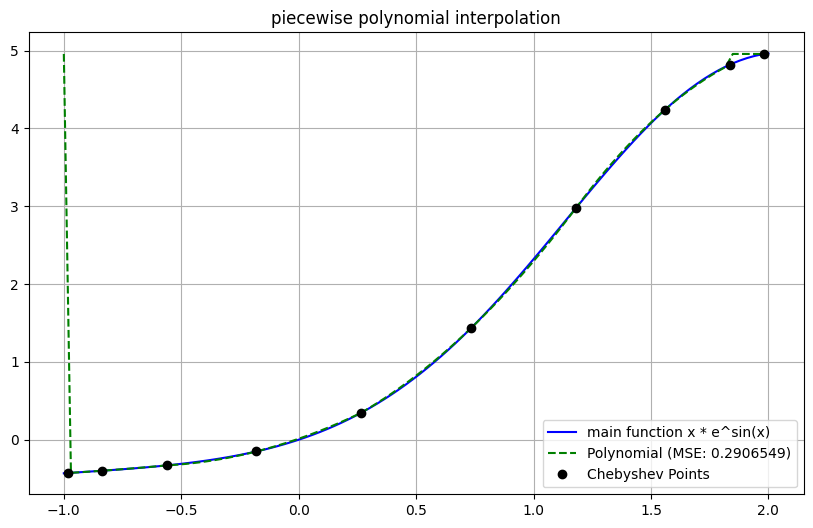

In [41]:
def piecewise_polynomial(x: float, x_points: np.ndarray, y_points: np.ndarray) -> float:
    n = len(x_points)
    for i in range(0, n-2, 2):
        if x_points[i] <= x <= x_points[min(i+2, n-1)]:
            x0, x1, x2 = x_points[i:i+3]
            y0, y1, y2 = y_points[i:i+3]
            
            L0 = ((x-x1)*(x-x2))/((x0-x1)*(x0-x2))
            L1 = ((x-x0)*(x-x2))/((x1-x0)*(x1-x2))
            L2 = ((x-x0)*(x-x1))/((x2-x0)*(x2-x1))
            
            return y0*L0 + y1*L1 + y2*L2
    return y_points[-1]

y_poly = np.array([piecewise_polynomial(x, x_cheb, y_cheb) for x in x_test])
mse_poly = np.mean((f(x_test) - y_poly)**2)

plt.figure(figsize=(10, 6))
plt.plot(x_test, f(x_test), 'b-', label='main function x * e^sin(x)')
plt.plot(x_test, y_poly, 'g--', label=f'Polynomial (MSE: {mse_poly:.7f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('piecewise polynomial interpolation')
plt.grid(True)
plt.legend()
plt.show()

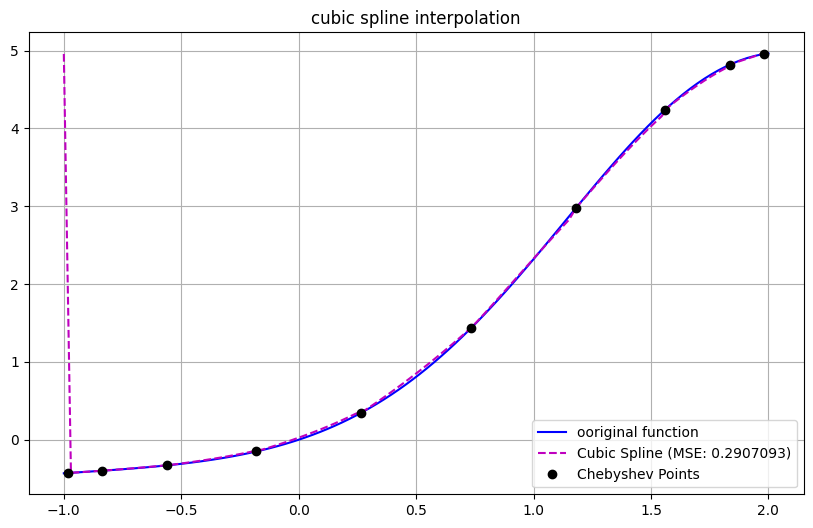

In [42]:
def cubic_spline(x_points: np.ndarray, y_points: np.ndarray) -> Callable:
    n = len(x_points)
    h = np.diff(x_points)
    
    # here we use trigiagonal sistem solving using thomas algirhtm as it was shown on the slides
    # its efficient so why not
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    A[0, 0] = 1
    A[-1, -1] = 1
    
    for i in range(1, n-1):
        A[i, i-1] = h[i-1]
        A[i, i] = 2*(h[i-1] + h[i])
        A[i, i+1] = h[i]
        
        b[i] = 3*((y_points[i+1] - y_points[i])/h[i] - 
                  (y_points[i] - y_points[i-1])/h[i-1])
    
    c = np.linalg.solve(A, b)
    
    def get_coefficients(i):
        a = y_points[i]
        b = (y_points[i+1] - y_points[i])/h[i] - h[i]*c[i]/3 - h[i]*c[i+1]/6
        return a, b, c[i], (c[i+1] - c[i])/(3*h[i])
    
    def spline(x):
        for i in range(n-1):
            if x_points[i] <= x <= x_points[i+1]:
                a, b, c, d = get_coefficients(i)
                dx = x - x_points[i]
                return a + b*dx + c*dx**2/2 + d*dx**3
        return y_points[-1]
    
    return spline

spline_func = cubic_spline(x_cheb, y_cheb)
y_spline = np.array([spline_func(x) for x in x_test])
mse_spline = np.mean((f(x_test) - y_spline)**2)

plt.figure(figsize=(10, 6))
plt.plot(x_test, f(x_test), 'b-', label='ooriginal function')
plt.plot(x_test, y_spline, 'm--', label=f'Cubic Spline (MSE: {mse_spline:.7f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('cubic spline interpolation')
plt.grid(True)
plt.legend()
plt.show()

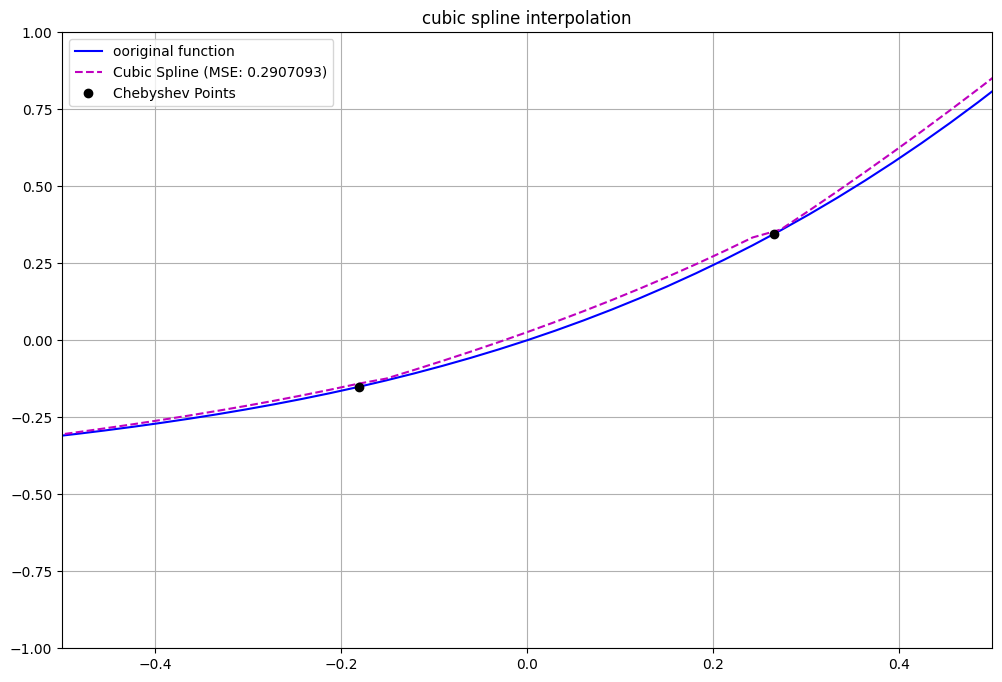

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(x_test, f(x_test), 'b-', label='ooriginal function')
plt.plot(x_test, y_spline, 'm--', label=f'Cubic Spline (MSE: {mse_spline:.7f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('cubic spline interpolation')
plt.xlim(-0.5, 0.5) 
plt.ylim(-1, 1) 

plt.grid(True)
plt.legend()
plt.show()

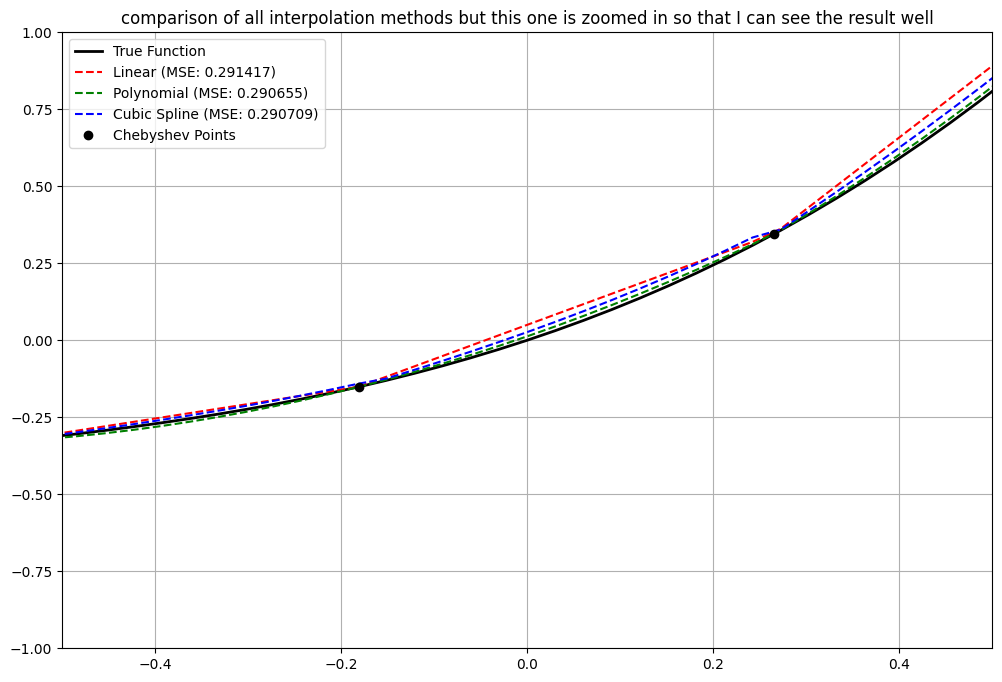

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(x_test, f(x_test), 'k-', label='True Function', linewidth=2)
plt.plot(x_test, y_linear, 'r--', label=f'Linear (MSE: {mse_linear:.6f})')
plt.plot(x_test, y_poly, 'g--', label=f'Polynomial (MSE: {mse_poly:.6f})')
plt.plot(x_test, y_spline, 'b--', label=f'Cubic Spline (MSE: {mse_spline:.6f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('comparison of all interpolation methods but this one is zoomed in so that I can see the result well')

plt.xlim(-0.5, 0.5) # here i use x lim and y lim to that i can zoom in the figure nicely
plt.ylim(-1, 1) 

plt.grid(True)
plt.legend()
plt.show()

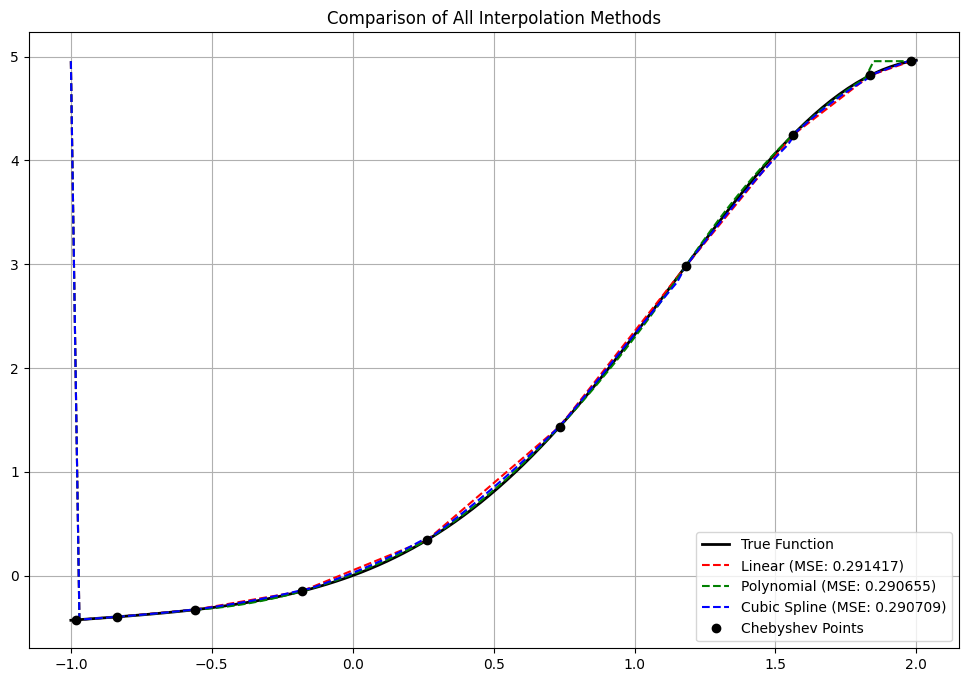


Mean Squared Error Comparison:
Linear Interpolation: 0.29141741
Polynomial Interpolation: 0.29065488
Cubic Spline Interpolation: 0.29070929

Best method: Polynomial with mena squared error of 0.290655


In [45]:
plt.figure(figsize=(12, 8))
plt.plot(x_test, f(x_test), 'k-', label='True Function', linewidth=2)
plt.plot(x_test, y_linear, 'r--', label=f'Linear (MSE: {mse_linear:.6f})')
plt.plot(x_test, y_poly, 'g--', label=f'Polynomial (MSE: {mse_poly:.6f})')
plt.plot(x_test, y_spline, 'b--', label=f'Cubic Spline (MSE: {mse_spline:.6f})')
plt.plot(x_cheb, y_cheb, 'ko', label='Chebyshev Points')
plt.title('Comparison of All Interpolation Methods')
plt.grid(True)
plt.legend()
plt.show()

print("\nMean Squared Error Comparison:")
print(f"Linear Interpolation: {mse_linear:.8f}")
print(f"Polynomial Interpolation: {mse_poly:.8f}")
print(f"Cubic Spline Interpolation: {mse_spline:.8f}")

best_method = min(
    ("Linear", mse_linear),
    ("Polynomial", mse_poly),
    ("Cubic Spline", mse_spline),
    key=lambda x: x[1]
)
print(f"\nBest method: {best_method[0]} with mena squared error of {best_method[1]:.6f}")